# Creating rasters of annual inundation metrics using Sentinel-2 

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Sandbox` environment
* **Products used:** 
[ga_s2am_ard_3](https://explorer.dea.ga.gov.au/products/ga_s2am_ard_3)  [ga_s2bm_ard_3](https://explorer.dea.ga.gov.au/products/ga_s2bm_ard_3)

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import xarray as xr

from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map, xr_animation
from odc.geo.geom import Geometry

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="S2_annual_metrics")

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Australia, see the [Dask notebook](../Beginners_guide/09_Parallel_processing_with_Dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in JupyterLab* section of the [Dask notebook](../Beginners_guide/09_Parallel_processing_with_Dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [3]:
client = create_local_dask_cluster(spare_mem='2Gb',display_client=True, return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/andres.sutton@student.unsw.edu.au/proxy/8787/status,
Dashboard: /user/andres.sutton@student.unsw.edu.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 13.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36297,Workers: 1
Dashboard: /user/andres.sutton@student.unsw.edu.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 13.14 GiB
Comm: tcp://127.0.0.1:33215,Total threads: 2
Dashboard: /user/andres.sutton@student.unsw.edu.au/proxy/38395/status,Memory: 13.14 GiB
Nanny: tcp://127.0.0.1:43485,


### Open shapefile of area of interest

Shapefile should be uploaded to Sandbox Environment

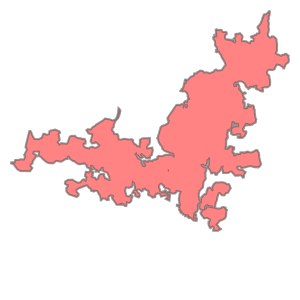

In [4]:
vector_file = 'Narran_Lakes_floodplain.shp' #The vector file you uploaded to your Sandbox

polygon_to_drill = gpd.read_file(vector_file)

# Select polygon
shapely_geometry = polygon_to_drill.iloc[0].geometry

# Convert to Geometry object with CRS information
geom = Geometry(geom=shapely_geometry, crs=polygon_to_drill.crs)

geom

## Load cloud-masked satellite data

The code below will create a query dictionary for our region of interest, and then load Sentinel-2 satellite data.
For more information on loading data, see the [Loading data notebook](../Beginners_guide/04_Loading_data.ipynb).

In [5]:
## Create a query object
query = {
    "geopolygon": geom,
    "resolution": (-10, 10),
    "time": ("2022-07-01", "2023-06-30"), #specify water year of interest
    "dask_chunks": {"time": -1, "x": 500, "y": 500},
    "output_crs": "EPSG:3577",
}

# load Sentinel 2 data
ds = load_ard(
    dc=dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    measurements=["nbart_swir_3", "nbart_green", "nbart_red", 'nbart_nir_1', 
                                "nbart_swir_2","oa_fmask"
                  ],
    cloud_mask="s2cloudless",
    min_gooddata=0.9,
    group_by="solar_day",
    **query
)



Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless


/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


Filtering to 37 out of 143 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Returning 37 time steps as a dask array


## Calculate the Fisher water index, binarise water and edit date type

IMPORTANT: change the reference date accordingly

In [6]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds['fwi'] = 1.7204 + 171*(ds.nbart_green/10000) + 3*(ds.nbart_red/10000) - 70*(ds.nbart_nir_1/10000) - 45*(ds.nbart_swir_2/10000)-71*(ds.nbart_swir_3/10000)

#Binarise water
ds['water'] = (ds['fwi'] >= -12.67).astype(np.int8)

# Define the reference period (start date)
reference_date = np.datetime64('2022-07-01')

# Transform date values to the number of days since the reference period
days_since_reference = (ds.time.values - reference_date).astype('timedelta64[D]').astype(int)

ds.coords["time"] = days_since_reference

ds

<xarray.Dataset> Size: 15GB
Dimensions:       (time: 37, y: 3224, x: 4283)
Coordinates:
  * y             (y) float64 26kB -3.316e+06 -3.316e+06 ... -3.349e+06
  * x             (x) float64 34kB 1.434e+06 1.434e+06 ... 1.477e+06 1.477e+06
    spatial_ref   int32 4B 3577
  * time          (time) int64 296B 8 13 18 23 28 108 ... 333 343 348 353 358
Data variables:
    nbart_swir_3  (time, y, x) float32 2GB dask.array<chunksize=(37, 500, 500), meta=np.ndarray>
    nbart_green   (time, y, x) float32 2GB dask.array<chunksize=(37, 500, 500), meta=np.ndarray>
    nbart_red     (time, y, x) float32 2GB dask.array<chunksize=(37, 500, 500), meta=np.ndarray>
    nbart_nir_1   (time, y, x) float32 2GB dask.array<chunksize=(37, 500, 500), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 2GB dask.array<chunksize=(37, 500, 500), meta=np.ndarray>
    oa_fmask      (time, y, x) float32 2GB dask.array<chunksize=(37, 500, 500), meta=np.ndarray>
    fwi           (time, y, x) float32 2GB dask.array<chunksize=(37, 500, 500), meta=np.ndarray>
    water         (time, y, x) int8 511MB dask.array<chunksize=(37, 500, 500), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [7]:
ds.time

<xarray.DataArray 'time' (time: 49)> Size: 392B
array([  8,  13,  18,  23,  33,  38,  43,  48,  53,  58,  63,  68,  73,  78,
        83,  93,  98, 103, 108, 113, 118, 123, 128, 133, 143, 148, 153, 158,
       163, 168, 173, 178, 183, 208, 223, 233, 248, 253, 273, 283, 288, 293,
       318, 323, 343, 348, 353, 358, 363])
Coordinates:
    spatial_ref  int32 4B 3577
  * time         (time) int64 392B 8 13 18 23 33 38 ... 323 343 348 353 358 363

### Functions to obtain longest inundation period and date of start. 

Creates 2 arrays which we then combine into a dataset to write into a tiff

In [7]:
def time_difference_slice(arr, times):
    diff = np.diff(arr, axis = 0)
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    if arr[0]:
        starts = np.insert(starts, 0, 0)
    if arr[-1]:
        ends = np.append(ends, len(diff))

    if len(starts) == 0 or len(ends) == 0:
        return 0  # Return default value if there are no valid starts or ends

    lengths = ends - starts
    if lengths.size == 0:
        return 0  # Return default value if no consecutive 1s are found

    max_len = np.max(lengths)
    idx = np.argmax(lengths)

    start_idx = starts[idx]
    end_idx = ends[idx] - 1

    start_time = times[start_idx]
    end_time = times[end_idx]

    if (end_time + 1) > start_time:
        time_difference = (end_time + 1) - start_time
    else:
        time_difference = 365 - start_time
    

    return time_difference

def start_time_slice(arr, times):
    diff = np.diff(arr, axis = 0)
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    if arr[0]:
        starts = np.insert(starts, 0, 0)
    if arr[-1]:
        ends = np.append(ends, len(diff))

    if len(starts) == 0 or len(ends) == 0:
        return np.nan  # Return default value if there are no valid starts or ends

    lengths = ends - starts
    if lengths.size == 0:
        return np.nan  # Return default value if no consecutive 1s are found

    idx = np.argmax(lengths)
    start_idx = starts[idx]

    end_idx = ends[idx] - 1

    start_time = times[start_idx]

        
    return start_time

length_array = xr.apply_ufunc(
    time_difference_slice,
    ds.water,
    ds.time,
    input_core_dims=[['time'], ['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

start_time_array = xr.apply_ufunc(
    start_time_slice,
    ds.water,
    ds.time,
    input_core_dims=[['time'], ['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)


dsyearlywaterdyn = xr.Dataset(
    {
        "length": (["y", "x"], length_array.data),
        "start_time": (["y", "x"], start_time_array.data),
    },
    coords={"x": ds.water.x, "y": ds.water.y}
) 

### Write the dataset into a tiff file. 

Output will save in DEA Sandbox directory from where it can be downloaded

In [8]:
%%time
# Write multi-band GeoTIFF to a location
from datacube.utils.cog import write_cog

dsyearlywaterdyn_array = dsyearlywaterdyn.to_array()


file = write_cog(dsyearlywaterdyn_array,
          fname='narran_annual_watermetrics_2223_new.tif',
          overwrite=True)


file.compute()

2025-07-24 02:46:23,216 - distributed.worker.memory - WARNING - gc.collect() took 1.004s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-07-24 02:55:19,957 - distributed.worker.memory - WARNING - gc.collect() took 1.136s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-07-24 03:11:12,298 - distributed.worker.memory - WARNING - gc.collect() took 1.469s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.


CPU times: user 8min 30s, sys: 26.3 s, total: 8min 56s
Wall time: 1h 10min 9s


PosixPath('narran_annual_watermetrics_2223_new.tif')

When done close the Dask client to release reources

In [12]:
client.close()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2024

**Compatible datacube version:**

In [22]:
print(datacube.__version__)

1.8.18
